### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

### slp from ncep-ncar - is it the same if you get monthly data from 4xdaily data, or if you take the long term mean?

yes, even though one is in milibars and the other is in pascals, but yes, you get the right answer. 


In [4]:
w = xr.open_dataset('slp.1994.nc')
w2 = xr.open_dataset('slp.mon.mean.nc')

In [5]:
mean_dat = w.slp.groupby('time.month').mean()

mean_dat2 = w2.slp.sel(time=slice(f'1994-01-01', '1994-12-31'))

vis = False

if vis:
    plt.figure()
    q = plt.pcolormesh(mean_dat[0,:,:]/100)
    plt.colorbar(q)

    plt.figure()
    q = plt.pcolormesh(mean_dat2[0,:,:])
    plt.colorbar(q)

    plt.figure()
    q = plt.pcolormesh(mean_dat2[0,:,:]-mean_dat[0,:,:]/100)
    plt.colorbar(q)

### OBS: 0Szonal_mean, 65S_zonal_mean

In [6]:
ex = False

if ex:
    time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
    # Create a 1D xarray.Dataset with a 'slp' variable, ensuring the data is float
    data = xr.Dataset(
        {
            "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
            "slp65S": (["time"], [float(i) for i in range(len(time))]), 
        },
        coords={
            "time": time  # time coordinate
        }
    )

    tw = pd.read_csv('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/obs/MSLP40S.txt', sep = ',')
    d = pd.date_range(start='1/1/1980', end='12/1/2022', freq='MS')    
    sam = np.random.rand(len(d))
    ind = 0
    for y in range(1980,2023):
        ty = np.array(tw.loc[tw['YEAR'] == y].values)

        sams = (ty[0][1:13])
        sam[ind:ind+12] = sams
        ind = ind+12

    sam40 = sam[0:492]

    tw = pd.read_csv('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/obs/MSLP65S.txt', sep = ',')
    d = pd.date_range(start='1/1/1980', end='12/1/2022', freq='MS')    
    sam = np.random.rand(len(d))
    ind = 0
    for y in range(1980,2023):
        ty = np.array(tw.loc[tw['YEAR'] == y].values)

        sams = (ty[0][1:13])
        sam[ind:ind+12] = sams
        ind = ind+12

    sam65 = sam[0:492]

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65
    
    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    data.to_netcdf('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/obs/SLP.nc')


## nasa-merra

In [7]:
ex = False
if ex:
    tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/MERRA/'
    mo = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

    sam40 = np.zeros(492)
    sam65 = np.zeros(492)

    ind = 0
    for yr in range(1980,2021):
        print(yr)
        for m in mo:
            w = f'{tdir}*{yr}{m}*nc*'
            w2 = glob.glob(w)
            v = xr.open_dataset(w2[0])
            q = v.SLP.sel(lat = -65).mean(dim = 'lon').mean(dim = 'time').values
            q2 = v.SLP.sel(lat = -40).mean(dim = 'lon').mean(dim = 'time').values
            sam40[ind] = q2/100
            sam65[ind] = q/100
            ind = ind+1
            if ind == 0:
                print(q)

    time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
    # Create a 1D xarray.Dataset with a 'slp' variable, ensuring the data is float
    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    data.to_netcdf('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/MERRA/SLP.nc')



## ncep_ncar

In [8]:
ex = False
if ex:
    w = xr.open_dataset('//gpfs/data/greenocean2/software/products/windsFromComponents/SAM/NCEP-NCAR/slp.mon.mean.nc')
    sam65 = w.slp.sel(lat = -65).mean(dim = 'lon').sel(time=slice(f'1980-01-01', '2020-12-31'))
    sam40 = w.slp.sel(lat = -40).mean(dim = 'lon').sel(time=slice(f'1980-01-01', '2020-12-31'))

    time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
    # Create a 1D xarray.Dataset with a 'slp' variable, ensuring the data is float
    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    data.to_netcdf('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/NCEP-NCAR/SLP.nc')

## NCEP DOE

In [9]:
ex = False
if ex:
    w = xr.open_dataset('//gpfs/data/greenocean2/software/products/windsFromComponents/SAM/NCEP-DOE/mslp.mon.mean.nc')
    sam65 = w.mslp.sel(lat = -65).mean(dim = 'lon').sel(time=slice(f'1980-01-01', '2020-12-31'))
    sam40 = w.mslp.sel(lat = -40).mean(dim = 'lon').sel(time=slice(f'1980-01-01', '2020-12-31'))

    time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
    # Create a 1D xarray.Dataset with a 'slp' variable, ensuring the data is float
    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40/100
    data['slp65S'].values = sam65/100

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    data.to_netcdf('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/NCEP-DOE/SLP.nc')

## ukesm...

In [10]:
ex = False
if ex:

    sam40 = np.zeros(492)
    sam65 = np.zeros(492)
    ind = 0
    for yr in range(1980,2021):
        print(yr)

        if yr < 2015:
            tdir = '/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/hist/u-bc370_hist/'
        else:
            tdir = '/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/ssp370/u-ce417_ssp370/'


        w1 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m01.nc')
        w4 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m04.nc')
        w7 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m07.nc')
        w10 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m10.nc')

        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m1_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m2_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m3_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m4_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m5_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m6_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m7_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m8_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m9_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m10_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m11_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m12_65f = np.interp(-65, xp, fp)

        ##
        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m1_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m2_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m3_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m4_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m5_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m6_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m7_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m8_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m9_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m10_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m11_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m12_40f = np.interp(-65, xp, fp)

        yr40 = np.array([m1_40f, m2_40f, m3_40f, m4_40f, m5_40f, m6_40f, m7_40f, m8_40f, m9_40f, m10_40f, m11_40f, m12_40f])
        yr65 = np.array([m1_65f, m2_65f, m3_65f, m4_65f, m5_65f, m6_65f, m7_65f, m8_65f, m9_65f, m10_65f, m11_65f, m12_65f])
        sam40[ind:ind+12] = yr40/100
        sam65[ind:ind+12] = yr65/100
        ind = ind+12


    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    data.to_netcdf('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SLP.nc')
    
    print('UKESM done')

## ukesm m2

In [ ]:
ex = False
if ex:

    sam40 = np.zeros(492)
    sam65 = np.zeros(492)
    ind = 0
    for yr in range(1980,2021):
        print(yr)

        if yr < 2015:
            tdir = '/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/hist/u-bc370_hist/'
        else:
            tdir = '/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/ssp370/u-ce417_ssp370/'


        w1 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m01.nc')
        w4 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m04.nc')
        w7 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m07.nc')
        w10 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m10.nc')

        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m1_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m2_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m3_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m4_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m5_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m6_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m7_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m8_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m9_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m10_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m11_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m12_65f = np.interp(-65, xp, fp)

        ##
        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m1_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m2_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m3_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m4_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m5_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m6_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m7_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m8_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m9_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m10_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m11_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m12_40f = np.interp(-65, xp, fp)

        yr40 = np.array([m1_40f, m2_40f, m3_40f, m4_40f, m5_40f, m6_40f, m7_40f, m8_40f, m9_40f, m10_40f, m11_40f, m12_40f])
        yr65 = np.array([m1_65f, m2_65f, m3_65f, m4_65f, m5_65f, m6_65f, m7_65f, m8_65f, m9_65f, m10_65f, m11_65f, m12_65f])
        sam40[ind:ind+12] = yr40/100
        sam65[ind:ind+12] = yr65/100
        ind = ind+12


    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    data.to_netcdf('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SLP.nc')
    
    print('UKESM done')

## ERA5

In [11]:
tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/ERA5'

ex = False

if ex:
    
    sam40 = np.zeros(492)
    sam65 = np.zeros(492)

    ind = 0

    for y in range(1980,2021):
        print(y)
        t65f = xr.open_dataset(f'{tdir}/65msl_{y}.nc')
        t40f = xr.open_dataset(f'{tdir}/40msl_{y}.nc')
        t40 = t40f.msl.values
        t65 = t65f.msl.values

        sam40[ind:ind+12] = t40
        sam65[ind:ind+12] = t65

        ind = ind+12

    time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
    
    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40/100
    data['slp65S'].values = sam65/100

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    data.to_netcdf('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/ERA5/SLP.nc')

## SAM_ERA5.py 

In [12]:
import xarray as xr
import numpy as np
yr = 1980
# tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/ERA5/'
# td = f'mean_sea_level_pressure_ERA5_{yr}.nc'
# w = xr.open_dataset(f'{tdir}{td}')
# print(np.nanmax(w.msl.values))

In [13]:
import xarray as xr
import numpy as np

ex = False

if ex:
    sam40 = np.zeros(492)
    sam65 = np.zeros(492)
    ind = 0
    for yr in range(1980,2021):
        print(yr)

        tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/ERA5/'
        td = f'mean_sea_level_pressure_ERA5_{yr}.nc'

        w = xr.open_dataset(f'{tdir}{td}')
        yr65 = w.msl.sel(latitude = -65).mean(dim = 'longitude').resample(time='M').mean()
        yr40 = w.msl.sel(latitude = -40).mean(dim = 'longitude').resample(time='M').mean()

        sam40[ind:ind+12] = yr40.values/100
        sam65[ind:ind+12] = yr65.values/100

        ind = ind+12
        
        data = xr.Dataset(
        {
            "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
            "slp65S": (["time"], [float(i) for i in range(len(time))]), 
        },
        coords={
            "time": time  # time coordinate
        }
        )

        data['slp40S'].values = sam40
        data['slp65S'].values = sam65

        data["slp40S"].attrs["units"] = "hPa"
        data["slp65S"].attrs["units"] = "hPa"

        data.to_netcdf('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/ERA5/SLP.nc')

### JRA sam index

In [14]:
ex = False
if ex:
    tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/JRA/'
    mo = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

    sam40 = np.zeros(492)
    sam65 = np.zeros(492)

    #ind = 0
    for yr in range(1980,2021):
        print(yr)
        sam40 = np.zeros(12)
        sam65 = np.zeros(12)
        ind = 0
        for m in mo:
            print(m)
            w = f'{tdir}*{yr}{m}*nc*'
            w2 = glob.glob(w)
            v = xr.open_dataset(w2[0])

            
            sam65[ind] = v['prmsl-msl-an-gauss'].isel(lat = 413).mean(dim = 'lon').resample(time='M').mean().values/100

            sam40[ind] = v['prmsl-msl-an-gauss'].isel(lat = 346).mean(dim = 'lon').resample(time='M').mean().values/100
            # q = v.SLP.sel(lat = -65).mean(dim = 'lon').mean(dim = 'time').values
            # q2 = v.SLP.sel(lat = -40).mean(dim = 'lon').mean(dim = 'time').values
            # sam40[ind] = q2/100
            # sam65[ind] = q/100
            ind = ind+1
            # if ind == 0:
                # print(q)
        time = pd.date_range(start=f"{yr}-01-01", end=f"{yr}-12-31", freq='M')

    #time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
    # Create a 1D xarray.Dataset with a 'slp' variable, ensuring the data is float
        data = xr.Dataset(
        {
            "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
            "slp65S": (["time"], [float(i) for i in range(len(time))]), 
        },
        coords={
            "time": time  # time coordinate
        }
        )

        data['slp40S'].values = sam40
        data['slp65S'].values = sam65

        data["slp40S"].attrs["units"] = "hPa"
        data["slp65S"].attrs["units"] = "hPa"

        data.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/JRA/SLP_{yr}.nc')
        print(f'saved {yr}')

        
def make_yearlist(yrst, yrend):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = (f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/JRA/SLP_{yrs[i]}.nc')
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

w = xr.open_mfdataset(make_yearlist(1980,2020))

w.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/JRA/SLP.nc')
print('kurva')

kurva


NameError: name 'v' is not defined

In [ ]:
# v['prmsl-msl-an-gauss'].isel(lat = 413).mean(dim = 'lon').resample(time='M').mean()

# v['prmsl-msl-an-gauss'].isel(lat = 346).mean(dim = 'lon').resample(time='M').mean()

## calculate the natural sam index

MERRA
NCEP-NCAR
NCEP-DOE
UKESM
ERA5
JRA


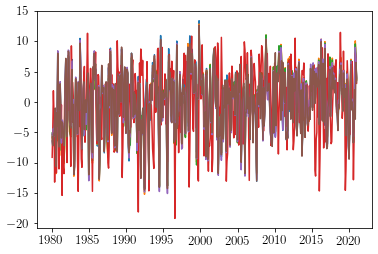

In [20]:
prods = ['MERRA','NCEP-NCAR','NCEP-DOE','UKESM','ERA5','JRA']

# prods = ['JRA']

ex = True

if ex:
    
    # prods = ['UKESM']

    for prod in prods:
        
        print(prod)
        
        w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SLP.nc')



        slp40S_a = w.slp40S - w.slp40S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

        slp65S_a = w.slp65S - w.slp65S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

        # plt.plot(w.time,slp40S_a,linestyle = ':',label = f'{prod}')
        # plt.plot(w.time,slp65S_a,linestyle = '-',label = f'{prod}')   
        plt.plot(w.time,slp40S_a-slp65S_a, label = prod)
        SAM = slp40S_a-slp65S_a
        w['SAM'] = (('time'), SAM)
        w.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')